<a href="https://colab.research.google.com/github/nhnam1105/LSTM-Attention-For-NLI/blob/master/LSTM_Self_Attention_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers
!pip install -U -q PyDrive
!pip install tensorflow_text
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 3.8 MB 40.8 MB/s 
     |████████████████████████████████| 6.5 MB 66.6 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 895 kB 74.2 MB/s 
     |████████████████████████████████| 596 kB 68.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 4.9 MB 34.0 MB/s 
     |████████████████████████████████| 462 kB 72.0 MB/s 
     |████████████████████████████████| 497.5 MB 23 kB/s 


In [3]:
# For File Handling
import csv
import os
import io
from os.path import join, exists

# For Data
import pandas as pd
import numpy as np

# For Processing
import re
import nltk
import string

# For Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
# For Word Embeddings
import gensim
import gensim.downloader as gensim_api

# For Deep Learning
from tensorflow import keras
import tensorflow.compat.v1 as tf
from tensorflow.keras import Model, models, layers, preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_file
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling1D, GlobalMaxPool1D, Embedding, Dense, Input, Dropout, Reshape, BatchNormalization, TimeDistributed, Lambda, Layer, LSTM, Bidirectional, Convolution1D, GRU, add, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import tensorflow_text as text
# Bert language model
import transformers
from transformers import TFAutoModel, AutoTokenizer, BertConfig, TFBertModel
# For Model Visualisation
import pydotplus
import pydot
import graphviz
#from keras.utils.vis_utils import model_to_dot
#For torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#keras.utils.vis_utils.pydot = pydot
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Miscellaneous 
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Reading csv data to python dataframe
train_df= pd.read_json("/content/drive/MyDrive/dataset/snli_1.0_train.jsonl", lines=True)
val_df= pd.read_json("/content/drive/MyDrive/dataset/snli_1.0_dev.jsonl", lines=True)
test_df=  pd.read_json("/content/drive/MyDrive/dataset/snli_1.0_test.jsonl", lines=True)

In [7]:
train_df = train_df[train_df['gold_label'] != "-"]
val_df= val_df[val_df['gold_label'] != "-"]
test_df= test_df[test_df['gold_label'] != "-"]

## Download GloVe

In [7]:
'''
data_folder = './datasets'
glove_url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
embedding_dim = 300
glove_filename = 'glove.840B.' + str(embedding_dim) + 'd.zip'
glove_loc = join(data_folder, glove_filename)

glove_filename = "/content/drive/MyDrive/dataset/glove.840B.300d.txt"

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))
'''

'\ndata_folder = \'./datasets\'\nglove_url = \'http://nlp.stanford.edu/data/glove.840B.300d.zip\'\nembedding_dim = 300\nglove_filename = \'glove.840B.\' + str(embedding_dim) + \'d.zip\'\nglove_loc = join(data_folder, glove_filename)\n\nglove_filename = "/content/drive/MyDrive/dataset/glove.840B.300d.txt"\n\nembeddings = {}\n\nprint(\'Extract %s\' % glove_filename)\nwith open(glove_filename, \'r\') as f:\n    for line in f:\n        values = line.split(\' \')\n        word = values[0]\n        embedding = np.asarray(values[1:], dtype=\'float32\')\n        embeddings[word] = embedding\n        \nprint(\'Embeddings size: %d\' % len(embeddings))\n'

In [8]:
train_df.iloc[0]

annotator_labels                                                  [neutral]
captionID                                                  3416050480.jpg#4
gold_label                                                          neutral
pairID                                                  3416050480.jpg#4r1n
sentence1                 A person on a horse jumps over a broken down a...
sentence1_binary_parse    ( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...
sentence1_parse           (ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...
sentence2                 A person is training his horse for a competition.
sentence2_binary_parse    ( ( A person ) ( ( is ( ( training ( his horse...
sentence2_parse           (ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
Name: 0, dtype: object

In [9]:
train_df_features = train_df[['sentence1', 'sentence2', 'gold_label']]
val_df_features = val_df[['sentence1', 'sentence2', 'gold_label']]
test_df_features = test_df[['sentence1', 'sentence2', 'gold_label']]

In [10]:
train_df_features.iloc[0]

sentence1     A person on a horse jumps over a broken down a...
sentence2     A person is training his horse for a competition.
gold_label                                              neutral
Name: 0, dtype: object

In [11]:
val_df_features.iloc[0]

sentence1     Two women are embracing while holding to go pa...
sentence2     The sisters are hugging goodbye while holding ...
gold_label                                              neutral
Name: 0, dtype: object

In [12]:
test_df_features.iloc[0]

sentence1     This church choir sings to the masses as they ...
sentence2                 The church has cracks in the ceiling.
gold_label                                              neutral
Name: 0, dtype: object

In [13]:
print(len(train_df_features))
print(len(val_df_features))
print(len(test_df_features))

549367
9842
9824


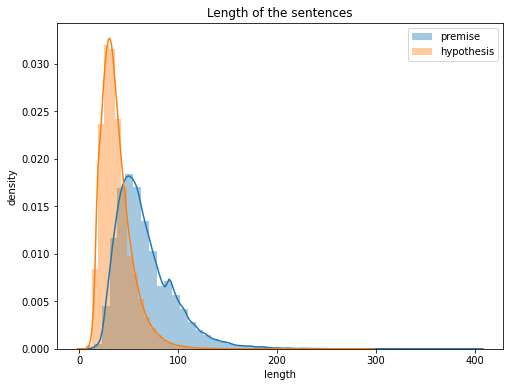

In [15]:
## LENGTH OF SENTENCES
for data in [train_df_features, val_df_features, test_df_features]:
    data['sent1_length'] = data.loc[:, 'sentence1'].str.len()
    data['sent2_length'] = data.loc[:, 'sentence2'].str.len()

plt.figure(figsize=(8, 6))
sns.distplot(train_df_features['sent1_length'], label = 'premise')
sns.distplot(train_df_features['sent2_length'], label = 'hypothesis')
plt.title('Length of the sentences')
plt.xlabel('length')
plt.ylabel('density')
plt.legend()

## DATA PREPROCESSING

In [14]:
def cleansing_text(text):
    # Remove punctuation and lower case
    cleaned_text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    return cleaned_text

train_df_features["sentence1"] = train_df_features["sentence1"].apply(lambda x: cleansing_text(x))
train_df_features["sentence2"] = train_df_features["sentence2"].apply(lambda x: cleansing_text(x))

val_df_features["sentence1"] = val_df_features["sentence1"].apply(lambda x: cleansing_text(x))
val_df_features["sentence2"] = val_df_features["sentence2"].apply(lambda x: cleansing_text(x))

test_df_features["sentence1"] = test_df_features["sentence1"].apply(lambda x: cleansing_text(x))
test_df_features["sentence2"] = test_df_features["sentence2"].apply(lambda x: cleansing_text(x))

In [15]:
input_df = list(train_df['sentence1']) + list(train_df['sentence2']) + list(val_df['sentence1']) + list(val_df['sentence2'])
tokenizer = preprocessing.text.Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(input_df)
word_index = tokenizer.word_index

In [16]:
## CONVERT TEXT TO SEQUENCE FOR TENSOR
def texts_to_sequences(texts):
    return tokenizer.texts_to_sequences(texts)

train_sequence_dict = dict()
val_sequence_dict = dict()
test_sequence_dict = dict()

# Create Train sequences
train_sequence_dict['sentence1'] = texts_to_sequences(train_df_features['sentence1'])
train_sequence_dict['sentence2'] = texts_to_sequences(train_df_features['sentence2'])

# Create Val sequences
val_sequence_dict['sentence1'] = texts_to_sequences(val_df_features['sentence1'])
val_sequence_dict['sentence2'] = texts_to_sequences(val_df_features['sentence2'])

# Create test sequences
test_sequence_dict['sentence1'] = texts_to_sequences(test_df_features['sentence1'])
test_sequence_dict['sentence2'] = texts_to_sequences(test_df_features['sentence2'])

## Word Embedding

In [17]:
embedding_model = gensim_api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [18]:
vector_size = 300

# Length of vocabulary is added a 1 to account for the OOV token
len_vocab = len(word_index)+1

# Create embedding matrix (length of vocabulary x vector size)
embeddings = np.zeros((len_vocab, vector_size))

for word,idx in word_index.items():
    # Update embeddings with pre-trained vectors if word exists
    try:
        embeddings[idx] = embedding_model[word]
        
    # If word does not exist, skip
    except:
        pass

In [19]:
embedding_dim = 300
batch_size = 512

In [20]:
len(input_df)

1118418

In [21]:
print('Found %s unique tokens.' % len(word_index))

Found 34607 unique tokens.


In [22]:
'''
words_len = min(NUM_WORDS, len(word_index))
# word_embedding_matrix = np.zeros((words_len + 1, embedding_dim))
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1
'''

'\nwords_len = min(NUM_WORDS, len(word_index))\n# word_embedding_matrix = np.zeros((words_len + 1, embedding_dim))\nword_embedding_matrix = np.random.random((words_len + 1, embedding_dim))\nk = 0\nfor word, i in word_index.items():\n    if i >= NUM_WORDS:\n        continue\n    embedding_vector = embeddings.get(word)\n    if embedding_vector is not None:\n        word_embedding_matrix[i] = embedding_vector\n        k += 1\n'

In [23]:
### PAD THE CREATED SUQUENCE
max_seq_length = 50
def pad_sequences(sequences, maxlen):
    return preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")

# Pad Train Sequences
train_sequence_dict['sentence1_padded'] = pad_sequences(train_sequence_dict['sentence1'], maxlen=max_seq_length)
train_sequence_dict['sentence2_padded'] = pad_sequences(train_sequence_dict['sentence2'], maxlen=max_seq_length)

# Pad Val Sequences
val_sequence_dict['sentence1_padded'] = pad_sequences(val_sequence_dict['sentence1'], maxlen=max_seq_length)
val_sequence_dict['sentence2_padded'] = pad_sequences(val_sequence_dict['sentence2'], maxlen=max_seq_length)

# Pad test Sequences
test_sequence_dict['sentence1_padded'] = pad_sequences(test_sequence_dict['sentence1'], maxlen=max_seq_length)
test_sequence_dict['sentence2_padded'] = pad_sequences(test_sequence_dict['sentence2'], maxlen=max_seq_length)

In [24]:
### LABEL ENCODING
label_index = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2,
}

def indexify_label(label):
    return label_index[label]

train_sequence_dict["label_index"] = train_df_features["gold_label"].apply(lambda x: indexify_label(x))
val_sequence_dict["label_index"] = val_df_features["gold_label"].apply(lambda x: indexify_label(x))
test_sequence_dict["label_index"] = test_df_features["gold_label"].apply(lambda x: indexify_label(x))

In [25]:
indexify_label("neutral")

1

In [26]:
# Model Training Inputs
t_1 = train_sequence_dict['sentence1_padded']
t_2 = train_sequence_dict['sentence2_padded']
t_y = train_sequence_dict['label_index']

# Model Validation Inputs
v_1 = val_sequence_dict['sentence1_padded']
v_2 = val_sequence_dict['sentence2_padded']
v_y = val_sequence_dict['label_index']

In [27]:
# Function to return an embedding layer
def embedding_layer(name, embeddings, num_nodes=16):
    return models.Sequential(
        [
            # Embedding Layer
            layers.Embedding(
                embeddings.shape[0],
                embeddings.shape[1],
                input_length=max_seq_length,
                weights=[embeddings],
                trainable=False,
            ),
        ], name=name)


# Function to return a feed-forward layer
def feed_forward_layer(name, num_nodes=200, activation="relu", dropout_rate=0):
    return models.Sequential(
        [
            layers.Dense(num_nodes, activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(num_nodes, activation=activation),
            layers.Dropout(dropout_rate),
        ], name=name)

# Function to carry out normalisation for soft-alignment
def normalizer(axis):
    def _normalize(vector_similarities):
        exp_weights = K.exp(vector_similarities)
        sum_weights = K.sum(exp_weights, axis=axis, keepdims=True)
        return exp_weights / sum_weights

    return _normalize

# Function to sum and return an aggregated vector
def aggregater(x):
    return K.sum(x, axis=1, keepdims=False)

In [28]:
def bilstm_layer(name, num_nodes=200, activation="relu", dropout_rate=0):
    return layers.Bidirectional(
            layers.LSTM(num_nodes, return_sequences=True, dropout=dropout_rate, activation=activation),
        name=name)

In [29]:
# Function to combine layers together and return the final dam_bilstm model
def build_dam_bilstm_model(num_nodes):
      
    # Input Layer
    x1 = layers.Input(shape=(max_seq_length,), name="Input_x1")
    x2 = layers.Input(shape=(max_seq_length,), name="Input_x2")
    
    # Embedding Layer
    embedding = embedding_layer("Embedding", embeddings)
    e1 = embedding(x1)
    e2 = embedding(x2)
        
    # -> Pass each word through a FFN with RelU activations to yield a non-linear transformation.
    feedforward_F = feed_forward_layer("FF_F", num_nodes, dropout_rate= 0.1)
    x1_nonlinear = feedforward_F(e1)
    x2_nonlinear = feedforward_F(e2)
    
    # -> Compute pairwise word similarity between every word in x1 compared to every word in x2, and vice versa.
    vector_similarities = layers.dot([x1_nonlinear, layers.Permute((2,1))(x2_nonlinear)], axes=(2,1), name="Pairwise_Similarity")
    
    # -> Compute Soft-Attention
    norm_similarities_x1 = layers.Lambda(normalizer(1), name="Normalise_Similarities_x1")(vector_similarities)
    norm_similarities_x2 = layers.Lambda(normalizer(2), name="Normalise_Similarities_x2")(vector_similarities)
    alpha = layers.dot([norm_similarities_x2, e1], axes=1, name="Alpha")
    beta = layers.dot([norm_similarities_x1, e2], axes=1, name="Beta")
        
    # Compare
    comp1 = layers.concatenate([e1, beta], name="Concat_x1_beta")
    comp2 = layers.concatenate([e2, alpha], name="Concat_x2_alpha")
    
    # BiLSTM_G isntead of FFN_G
    bilstm_G = bilstm_layer("BiLSTM_G", num_nodes=num_nodes, dropout_rate= 0)
    v1 = bilstm_G(comp1)
    v2 = bilstm_G(comp2)
    
    # Aggregate
    v1_sum = layers.Lambda(aggregater, name="Aggregate_v1")(v1)
    v2_sum = layers.Lambda(aggregater, name="Aggregate_v2")(v2)
    concat = layers.concatenate([v1_sum, v2_sum], name="Concat_v1_v2")
    
    # Output Layer
    feedforward_H = feed_forward_layer("FF_H", num_nodes, dropout_rate= 0.1)
    y = feedforward_H(concat)
    y = layers.Dense(3, activation="softmax", name="Output")(y)
        
    model = Model(inputs=[x1, x2], outputs=y)
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer=Adam(lr=0.0005),
    )

    return model

In [30]:
dam_bilstm_model = build_dam_bilstm_model(200)
dam_bilstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_x1 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 Input_x2 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 Embedding (Sequential)         (None, 50, 300)      10382400    ['Input_x1[0][0]',               
                                                                  'Input_x2[0][0]']               
                                                                                                  
 FF_F (Sequential)              (None, 50, 200)      100400      ['Embedding[0][0]',          

In [31]:
monitor = EarlyStopping(monitor='val_loss', patience = 5)
#dam_bilstm_checkpointer = ModelCheckpoint(filepath=dam_bilstm_save_file, save_best_only=True)
# Train DAM BiLSTM model
trained_dam_bilstm_model = dam_bilstm_model.fit(
    [t_1, t_2], t_y,
    validation_data=([v_1, v_2], v_y),
    callbacks=[monitor],
    batch_size=512,
    epochs=50,
)

Epoch 1/50
1073/1073 [==============================] - 298s 272ms/step - loss: 0.6855 - accuracy: 0.7037 - val_loss: 0.5059 - val_accuracy: 0.8024
Epoch 2/50
1073/1073 [==============================] - 292s 272ms/step - loss: 0.5177 - accuracy: 0.7945 - val_loss: 0.4503 - val_accuracy: 0.8234
Epoch 3/50
1073/1073 [==============================] - 291s 271ms/step - loss: 0.4709 - accuracy: 0.8161 - val_loss: 0.4300 - val_accuracy: 0.8309
Epoch 4/50
1073/1073 [==============================] - 292s 272ms/step - loss: 0.4400 - accuracy: 0.8297 - val_loss: 0.4192 - val_accuracy: 0.8404
Epoch 5/50
1073/1073 [==============================] - 290s 271ms/step - loss: 0.4150 - accuracy: 0.8406 - val_loss: 0.4182 - val_accuracy: 0.8435
Epoch 6/50
1073/1073 [==============================] - 290s 271ms/step - loss: 0.3936 - accuracy: 0.8501 - val_loss: 0.4092 - val_accuracy: 0.8438
Epoch 7/50
1073/1073 [==============================] - 291s 272ms/step - loss: 0.3732 - accuracy: 0.8582 - val_

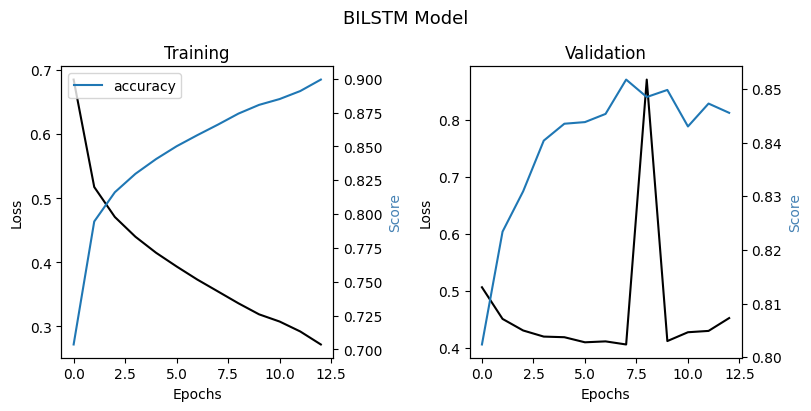

In [32]:
metrics = [k for k in trained_dam_bilstm_model.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8,4), dpi= 100)
fig.suptitle("BILSTM Model", fontsize=13)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(trained_dam_bilstm_model.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(trained_dam_bilstm_model.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(trained_dam_bilstm_model.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(trained_dam_bilstm_model.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [5]:
class SelfAttention_Module(nn.Module):
    def __init__(self, hidden_dim, use_BN=False, dropout_rate=0.0):
        super(SelfAttention_Module, self).__init__()
        def MLP(input_dim, output_dim, use_BN, dropout_rate):
            layers = []
            layers.append(nn.Linear(input_dim, output_dim))
            if use_BN:
                layers.append(nn.BatchNorm1d(output_dim, affine=True))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_rate))

            layers.append(nn.Linear(output_dim, output_dim))
            layers.append(nn.ReLU())

            mlp = nn.Sequential(*layers)

            return mlp
        
        self.hidden_dim = hidden_dim
        self.F = MLP(hidden_dim, hidden_dim, use_BN, dropout_rate)
        self.G = MLP(hidden_dim * 2, hidden_dim, use_BN, dropout_rate)
        self.H = MLP(hidden_dim * 2, hidden_dim, use_BN, dropout_rate)
        #self.LSTM = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        
    def forward(self, a, b):
        l_a = a.shape[1]
        l_b = b.shape[1]
        
        a = self.F(a.view(-1, self.hidden_dim)) # a: ((batch_size * l_a) x hidden_dim)
        a = a.view(-1, l_a, self.hidden_dim) # a: (batch_size x l_a x hidden_dim)
        b = self.F(b.view(-1, self.hidden_dim))  # b: ((batch_size * l_b) x hidden_dim)
        b = b.view(-1, l_b, self.hidden_dim) # b: (batch_size x l_b x hidden_dim)
        
        # equation (1) in paper:
        e = torch.bmm(a, torch.transpose(b, 1, 2)) # e: (batch_size x l_a x l_b)
        
        # equation (2) in paper:
        beta = torch.bmm(F.softmax(e, dim=2), b)  # beta: (batch_size x l_a x hidden_dim)
        alpha = torch.bmm(F.softmax(torch.transpose(e, 1, 2), dim=2), a) # alpha: (batch_size x l_b x hidden_dim)
        
        
        # equation (3) in paper:
        a_cat_beta = torch.cat((a, beta), dim=2)
        b_cat_alpha = torch.cat((b, alpha), dim=2)
        v1 = self.G(a_cat_beta.view(-1, 2 * self.hidden_dim)) # v1: ((batch_size * l_a) x hidden_dim)
        v2 = self.G(b_cat_alpha.view(-1, 2 * self.hidden_dim)) # v2: ((batch_size * l_b) x hidden_dim)
        
        # equation (4) in paper:
        v1 = torch.sum(v1.view(-1, l_a, self.hidden_dim), dim=1) # v1: (batch_size x 1 x hidden_dim)
        v2 = torch.sum(v2.view(-1, l_b, self.hidden_dim), dim=1) # v2: (batch_size x 1 x hidden_dim)
        
        v1 = torch.squeeze(v1, dim=1)
        v2 = torch.squeeze(v2, dim=1)
        
        # equation (5) in paper:
        v1_cat_v2 = torch.cat((v1, v2), dim=1) # v1_cat_v2: (batch_size x (hidden_dim * 2))
        h = self.H(v1_cat_v2)
        
        return h

In [6]:
class LSTM_Module(nn.Module):
    def __init__(self, hidden_dim, num_layers=2, bidirectional=True, dropout_rate=0.0):
        super(LSTM_Module, self).__init__()
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        self.hidden_dim = hidden_dim
        
        self.LSTM = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim * self.num_directions * self.num_layers * 2, hidden_dim)
        
    def forward(self, a, b):
        _, (_, v1) = self.LSTM(a)
        _, (_, v2) = self.LSTM(b)
        
#         v1 = torch.squeeze(v1, dim=0)
#         v2 = torch.squeeze(v2, dim=0)
        v1 = v1.permute(1, 0, 2).contiguous().view((-1, self.hidden_dim * self.num_directions * self.num_layers))
        v2 = v2.permute(1, 0, 2).contiguous().view((-1, self.hidden_dim * self.num_directions * self.num_layers))
        
        v1_cat_v2 = torch.cat((v1, v2), dim=1) # v1_cat_v2: (batch_size x (hidden_dim * 2))
        h = self.fc(v1_cat_v2)
        h = F.relu(h)
        
        return h

In [7]:
import h5py
f = h5py.File("/content/drive/MyDrive/dataset/glove.hdf5", 'r')
wordvec_matrix = torch.from_numpy(np.array(f['word_vecs'], dtype=np.float32))

In [8]:
embedd_dim = wordvec_matrix.shape[1]
embedd = nn.Embedding.from_pretrained(wordvec_matrix)

In [9]:
class Model(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, feature_extractor='attention', use_BN=False, dropout_rate=0.0):
        super(Model, self).__init__()
        # embedding
        self.embedding_dim = embedd_dim
        self.hidden_dim = hidden_dim
        self.embedding = embedd
        
        self.feature_extractor = feature_extractor
        assert feature_extractor in ['attention', 'lstm']
        if feature_extractor == 'attention':
          self.feature_extractor_module = SelfAttention_Module(hidden_dim, use_BN, dropout_rate)
        else:
          self.feature_extractor_module = LSTM_Module(hidden_dim, dropout_rate=dropout_rate)
        self.LSTM = nn.LSTM(input_size=self.embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=False)
        
        
        # linear transformation from embedding
        self.input_fc = nn.Linear(self.embedding_dim, hidden_dim, bias=True)
        # linear transformation to prediction
        self.output_fc = nn.Linear(hidden_dim, 3, bias=True)
        
    def forward(self, a, b):
        l_a = a.shape[1]
        l_b = b.shape[1]
        
        a = self.embedding(a) # a: (batch_size x l_a x embedding_dim)
        b = self.embedding(b) # b: (batch_size x l_b x embedding_dim)
        
        a = self.input_fc(a.view(-1, self.embedding_dim))
        b = self.input_fc(b.view(-1, self.embedding_dim))
        a = a.view(-1, l_a, self.hidden_dim) # a: (batch_size x l_a x hidden_dim)
        b = b.view(-1, l_b, self.hidden_dim) # b: (batch_size x l_b x hidden_dim)
        '''
        else:
            a, (_, _) = self.LSTM(a)
            b, (_, _) = self.LSTM(b)
            a = a.contiguous().view(-1, l_a, self.hidden_dim)
            b = b.contiguous().view(-1, l_b, self.hidden_dim)
        '''
        h = self.feature_extractor_module(a, b)
        
        y_hat = self.output_fc(h)
        
        return y_hat

In [10]:
class SNLI_data(object):
    '''
        class to handle training data
    '''

    def __init__(self, fname, use_padding=True, batch_size=256):
        self.use_padding = use_padding
        self.batch_size = batch_size

        f = h5py.File(fname, 'r')
        self.source = torch.from_numpy(np.array(f['source'])) - 1
        self.target = torch.from_numpy(np.array(f['target'])) - 1
        
        self.label = torch.from_numpy(np.array(f['label'])) - 1
        self.label_size = torch.from_numpy(np.array(f['label_size']))
        self.source_l = torch.from_numpy(np.array(f['source_l']))
        self.target_l = torch.from_numpy(np.array(f['target_l'])) # max target length each batch
        # idx in torch style; indicate the start index of each batch (starting
        # with 1)
        self.batch_idx = torch.from_numpy(np.array(f['batch_idx'])) - 1
        self.batch_l = torch.from_numpy(np.array(f['batch_l']))

        self.batches = []   # batches

        self.length = self.batch_l.size(0)  # number of batches

        self.size = 0   # number of sentences

    def get_batches(self):
        if self.use_padding:
            self.batches = []
            num_samples = self.source.shape[0]
            idx = np.arange(num_samples)
            np.random.shuffle(idx)
            self.source = self.source[idx]
            self.target = self.target[idx]
            self.label = self.label[idx]
            for i in range(0, num_samples - self.batch_size, self.batch_size):
                batch = (self.source[i : i + self.batch_size].type(torch.LongTensor),
                           self.target[i : i + self.batch_size].type(torch.LongTensor),
                           self.label[i : i + self.batch_size].type(torch.LongTensor))
                self.batches.append(batch)
        else:
            if self.batches == []:
                for i in range(self.length):
                    batch = (self.source[self.batch_idx[i] : self.batch_idx[i] + self.batch_l[i]][:, :self.source_l[i]].type(torch.LongTensor),
                           self.target[self.batch_idx[i] : self.batch_idx[i] + self.batch_l[i]][:, :self.target_l[i]].type(torch.LongTensor),
                           self.label[self.batch_idx[i] : self.batch_idx[i] + self.batch_l[i]].type(torch.LongTensor))
                    self.batches.append(batch)
                    self.size += self.batch_l[i]
        return self.batches

In [11]:
use_padding = False
train_data = SNLI_data("/content/drive/MyDrive/dataset/train.hdf5", use_padding=use_padding)
dev_data = SNLI_data("/content/drive/MyDrive/dataset/dev.hdf5", use_padding=use_padding)
test_data = SNLI_data("/content/drive/MyDrive/dataset/test.hdf5", use_padding=use_padding)

In [12]:
if  torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print("Found device: ", device)

Found device:  cuda


In [13]:
model_attention = Model(embedding_matrix=wordvec_matrix, hidden_dim=200, feature_extractor='attention', dropout_rate=0.2).to(device)
optimizer = optim.Adam(model_attention.parameters(), lr=2e-4)

In [14]:
print(model_attention)

Model(
  (embedding): Embedding(28754, 300)
  (feature_extractor_module): SelfAttention_Module(
    (F): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=200, out_features=200, bias=True)
      (4): ReLU()
    )
    (G): Sequential(
      (0): Linear(in_features=400, out_features=200, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=200, out_features=200, bias=True)
      (4): ReLU()
    )
    (H): Sequential(
      (0): Linear(in_features=400, out_features=200, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=200, out_features=200, bias=True)
      (4): ReLU()
    )
  )
  (LSTM): LSTM(300, 200, batch_first=True)
  (input_fc): Linear(in_features=300, out_features=200, bias=True)
  (output_fc): Linear(in_features=200, out_features=3, bias=True)
)


In [15]:
if not os.path.exists("./saved_model"):
  os.mkdir("./saved_model")
model_path = "./saved_model/model_attention.pt"

In [16]:
def evaluate(model, data, device):
    corrects = 0
    num_samples = 0
    batches = data.get_batches()
    for i, batch in enumerate(batches):
        source, target, label = batch
        source = source.to(device)
        target = target.to(device)
        label = label.to(device)
        
        y_hat = model(source, target)
        corrects += torch.sum(torch.argmax(y_hat, dim=1) == label).item()
        num_samples += target.shape[0]
    return corrects / num_samples

In [17]:
model_loss = []

In [18]:
def run(model, optimizer, train_data, dev_data, test_data, max_epochs, device, model_path):
    accs = []
    best_acc_test = 0
    for epoch in range(1, max_epochs + 1):
        print("epoch: ", epoch)
        train_batches = train_data.get_batches()
        random.shuffle(train_batches)
        model.train()
        corrects = 0
        num_samples = 0
        
        for i, batch in enumerate(train_batches):
            source, target, label = batch
            source = source.to(device)
            target = target.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            y_hat = model(source, target)
            
            # calculate the accuracy on training batch
            corrects += torch.sum(torch.argmax(y_hat, dim=1) == label).item()
            num_samples += target.shape[0]
            
            loss = torch.nn.CrossEntropyLoss()(y_hat, label)
            
            loss.backward()
            optimizer.step()

            if i % 1000 == 0:
                print("{}/{}\tLoss: {:.5f}\tAccuracy: {:.5f}".format(i, len(train_batches), loss, corrects / num_samples))
        
        # Calculate val accuracy        
        model.eval()
        print("Validation accuracy: {:.5f}".format(evaluate(model, dev_data, device)))
        model_loss.append(evaluate(model, dev_data, device))
        
        if corrects / num_samples > best_acc_test:
            print("Save model at {}".format(model_path))
            torch.save(model, model_path)
          
    model = torch.load(model_path)
    print("Test accuracy: {:.5f}".format(evaluate(model, test_data, device)))

In [19]:
run(model=model_attention,  \
              optimizer=optimizer, \
              train_data=train_data, \
              dev_data=dev_data, \
              test_data=test_data, \
              max_epochs=20, \
              device=device, \
              model_path=model_path)

epoch:  1
0/18183	Loss: 1.09647	Accuracy: 0.43750
1000/18183	Loss: 1.02236	Accuracy: 0.42145
2000/18183	Loss: 0.17615	Accuracy: 0.45541
3000/18183	Loss: 0.90990	Accuracy: 0.46826
4000/18183	Loss: 0.79688	Accuracy: 0.47961
5000/18183	Loss: 0.94694	Accuracy: 0.49545
6000/18183	Loss: 0.93777	Accuracy: 0.51019
7000/18183	Loss: 0.78926	Accuracy: 0.52144
8000/18183	Loss: 1.05160	Accuracy: 0.53120
9000/18183	Loss: 1.07212	Accuracy: 0.53921
10000/18183	Loss: 0.61091	Accuracy: 0.54662
11000/18183	Loss: 0.35746	Accuracy: 0.55323
12000/18183	Loss: 0.85617	Accuracy: 0.55913
13000/18183	Loss: 0.65404	Accuracy: 0.56416
14000/18183	Loss: 0.73032	Accuracy: 0.56865
15000/18183	Loss: 0.79760	Accuracy: 0.57337
16000/18183	Loss: 0.96615	Accuracy: 0.57759
17000/18183	Loss: 0.75193	Accuracy: 0.58117
18000/18183	Loss: 0.73776	Accuracy: 0.58460
Validation accuracy: 0.65989
Save model at ./saved_model/model_attention.pt
epoch:  2
0/18183	Loss: 0.63246	Accuracy: 0.78125
1000/18183	Loss: 0.92314	Accuracy: 0.6495

In [ ]:
'''
metrics = [k for k in model.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8,4), dpi= 100)
fig.suptitle("DAM Model", fontsize=13)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(model.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(model.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(model.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(model.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()
'''

In [1]:
#metrics = [k for k in model.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8,4), dpi= 100)
fig.suptitle("DAM Model", fontsize=13)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(model_loss, color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')

#ax11.plot(model.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(model_loss, color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
#for metric in metrics:
#     ax22.plot(model.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

NameError: ignored

In [20]:
model_lstm = Model(embedding_matrix=wordvec_matrix, hidden_dim=200, feature_extractor='lstm', dropout_rate=0.2).to(device)
optimizer = optim.Adam(model_lstm.parameters(), lr=2e-4)
model_path = "./saved_model/model_lstm.pt"

In [21]:
print(model_lstm)

Model(
  (embedding): Embedding(28754, 300)
  (feature_extractor_module): LSTM_Module(
    (LSTM): LSTM(200, 200, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=1600, out_features=200, bias=True)
  )
  (LSTM): LSTM(300, 200, batch_first=True)
  (input_fc): Linear(in_features=300, out_features=200, bias=True)
  (output_fc): Linear(in_features=200, out_features=3, bias=True)
)


In [22]:
run(model=model_lstm,  \
              optimizer=optimizer, \
              train_data=train_data, \
              dev_data=dev_data, \
              test_data=test_data, \
              max_epochs=20, \
              device=device, \
              model_path=model_path)

epoch:  1
0/18183	Loss: 1.10398	Accuracy: 0.25000
1000/18183	Loss: 0.78804	Accuracy: 0.48716
2000/18183	Loss: 0.76403	Accuracy: 0.52532
3000/18183	Loss: 0.95231	Accuracy: 0.54371
4000/18183	Loss: 0.81703	Accuracy: 0.55522
5000/18183	Loss: 0.81572	Accuracy: 0.56305
6000/18183	Loss: 0.87143	Accuracy: 0.57047
7000/18183	Loss: 1.00212	Accuracy: 0.57717
8000/18183	Loss: 0.82217	Accuracy: 0.58352
9000/18183	Loss: 0.91020	Accuracy: 0.58947
10000/18183	Loss: 0.84394	Accuracy: 0.59443
11000/18183	Loss: 0.57478	Accuracy: 0.59932
12000/18183	Loss: 0.68381	Accuracy: 0.60351
13000/18183	Loss: 0.77701	Accuracy: 0.60770
14000/18183	Loss: 0.79252	Accuracy: 0.61127
15000/18183	Loss: 0.65072	Accuracy: 0.61460
16000/18183	Loss: 0.82469	Accuracy: 0.61760
17000/18183	Loss: 0.80252	Accuracy: 0.62017
18000/18183	Loss: 0.65710	Accuracy: 0.62303
Validation accuracy: 0.67412
Save model at ./saved_model/model_lstm.pt
epoch:  2
0/18183	Loss: 0.73237	Accuracy: 0.59375
1000/18183	Loss: 0.76757	Accuracy: 0.67350
200